In [2]:
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
#загрузка массива данных для обучения моделей
filename='data'

imall,yy = pickle.load(open(filename, 'rb'))
# масштабирование величины яркости пикселей из формы 0-255 в форму 0 - 1
imall=imall/255.0
yy.shape

(524822,)

1.0

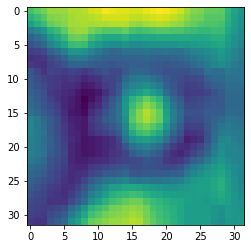

In [3]:
#отрисовка элемената b и вывод значения сфера или нет
b=4121
plt.imshow(np.reshape(imall[b,:],(32,32)))
yy[b]

In [4]:
#разбивка массива анных на тестовую 2% и обучающую выборки 98%
from sklearn.model_selection import  train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(imall,yy,random_state=0,test_size=0.02)


#преобразование формы массива для ее соответствия функции fit керас
Xtrain=np.reshape(Xtrain,(len(Xtrain),32,32,1)).astype('float32')
ytrain=np.reshape(ytrain,(len(ytrain),1)).astype('float32')
Xtest=np.reshape(Xtest,(len(Xtest),32,32,1)).astype('float32')
ytest=np.reshape(ytest,(len(ytest),1)).astype('float32')

ytr1=np.zeros((len(ytrain),1))
ytr2=np.zeros((len(ytrain),1))
ytr1[ytrain==0]=1
ytr1[ytrain==1]=1
ytr=np.hstack((ytr1,ytr2))

yte1=np.zeros((len(ytest),1))
yte2=np.zeros((len(ytest),1))
yte1[ytest==0]=1
yte1[ytest==1]=1
yte=np.hstack((yte1,yte2))

In [5]:
#загрузка керас и тензорфлоу
import os
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
import cv2
import os
import math
import random
import pickle
#keras import and windows InteractiveSession bug fix
from tensorflow.keras.optimizers import SGD,schedules
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics as ms
from tensorflow.keras import  Model
from tensorflow.keras.layers import Input,Conv2D, Concatenate, MaxPooling2D,Activation,concatenate,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization,Flatten,Dense,Reshape

import tensorflow.keras.backend as K


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D,Conv2DTranspose,Input
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization

In [6]:
from tensorflow.keras.models import load_model
#обучение 7 разных моделей с кратно увеличивающимся количеством конволюционных слоев
dim=1
modelhs=[]
ps=32
for i in range(7): #7
    print(dim)
    model = tf.keras.Sequential()
    
    model.add(Conv2D(dim, kernel_size=(3,3), padding='same', input_shape=(ps, ps, 1), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(dim, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(dim*2, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(dim*2, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    '''
    
    model.add(Flatten(input_shape=(32, 32, 1)))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='relu'))
    model.add(BatchNormalization())  
    '''    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.SGD(lr=0.01, decay=0.025 / 200, momentum=0.9, nesterov=False)
    model.compile(optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy'])


    class_weights = {0: 1.,
                    1: 13.5}


    model.summary()
    # train the network
    H=model.fit(Xtrain, ytrain, epochs=200, validation_data=(Xtest, ytest),class_weight =class_weights, verbose=1,shuffle = True, batch_size=1000)
    model.save('model16x'+str(dim)+'.h5', overwrite=True)
    #формирование массива с историей обучения моделей
    modelhs.append(dim)
    modelhs.append(H.history['loss'])
    modelhs.append(H.history["val_loss"])
    modelhs.append(H.history["accuracy"])
    modelhs.append(H.history["val_accuracy"])
    dim=dim*2
    


1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 1)         10        
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 1)         10        
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 1)        4         
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 1)        0         
 )                                                               
                                                      

c:\python\python38\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
515/515 [==============================] - 15s 18ms/step - loss: 0.7484 - accuracy: 0.7992 - val_loss: 0.4556 - val_accuracy: 0.8189
Epoch 2/200
515/515 [==============================] - 9s 17ms/step - loss: 0.4637 - accuracy: 0.9112 - val_loss: 0.3733 - val_accuracy: 0.8527
Epoch 3/200
515/515 [==============================] - 9s 17ms/step - loss: 0.4076 - accuracy: 0.9199 - val_loss: 0.3429 - val_accuracy: 0.8661
Epoch 4/200
515/515 [==============================] - 9s 17ms/step - loss: 0.3851 - accuracy: 0.9226 - val_loss: 0.2975 - val_accuracy: 0.8821
Epoch 5/200
515/515 [==============================] - 9s 17ms/step - loss: 0.3729 - accuracy: 0.9242 - val_loss: 0.2889 - val_accuracy: 0.8873
Epoch 6/200
515/515 [==============================] - 9s 17ms/step - loss: 0.3617 - accuracy: 0.9259 - val_loss: 0.2782 - val_accuracy: 0.8890
Epoch 7/200
515/515 [==============================] - 9s 17ms/step - loss: 0.3511 - accuracy: 0.9273 - val_loss: 0.2334 - val_accuracy

515/515 [==============================] - 8s 16ms/step - loss: 0.2721 - accuracy: 0.9375 - val_loss: 0.2483 - val_accuracy: 0.8964
Epoch 58/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2702 - accuracy: 0.9383 - val_loss: 0.3084 - val_accuracy: 0.8718
Epoch 59/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2689 - accuracy: 0.9379 - val_loss: 0.2973 - val_accuracy: 0.8711
Epoch 60/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2685 - accuracy: 0.9385 - val_loss: 0.2457 - val_accuracy: 0.8960
Epoch 61/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2665 - accuracy: 0.9387 - val_loss: 0.2474 - val_accuracy: 0.8987
Epoch 62/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2717 - accuracy: 0.9383 - val_loss: 0.2338 - val_accuracy: 0.9034
Epoch 63/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2682 - accuracy: 0.9385 - val_loss: 0.2355 - val_accuracy: 0.902

515/515 [==============================] - 8s 16ms/step - loss: 0.2506 - accuracy: 0.9417 - val_loss: 0.2432 - val_accuracy: 0.9024
Epoch 114/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2540 - accuracy: 0.9415 - val_loss: 0.2395 - val_accuracy: 0.9048
Epoch 115/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2478 - accuracy: 0.9425 - val_loss: 0.2298 - val_accuracy: 0.9096
Epoch 116/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2499 - accuracy: 0.9425 - val_loss: 0.2554 - val_accuracy: 0.8971
Epoch 117/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2530 - accuracy: 0.9420 - val_loss: 0.2456 - val_accuracy: 0.9013
Epoch 118/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2518 - accuracy: 0.9421 - val_loss: 0.2453 - val_accuracy: 0.9007
Epoch 119/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2536 - accuracy: 0.9415 - val_loss: 0.2478 - val_accuracy:

515/515 [==============================] - 8s 16ms/step - loss: 0.2441 - accuracy: 0.9435 - val_loss: 0.2360 - val_accuracy: 0.9044
Epoch 170/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2406 - accuracy: 0.9441 - val_loss: 0.2602 - val_accuracy: 0.8944
Epoch 171/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2437 - accuracy: 0.9435 - val_loss: 0.2450 - val_accuracy: 0.9030
Epoch 172/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2425 - accuracy: 0.9437 - val_loss: 0.2271 - val_accuracy: 0.9097
Epoch 173/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2440 - accuracy: 0.9433 - val_loss: 0.2653 - val_accuracy: 0.8921
Epoch 174/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2412 - accuracy: 0.9442 - val_loss: 0.2367 - val_accuracy: 0.9078
Epoch 175/200
515/515 [==============================] - 8s 16ms/step - loss: 0.2407 - accuracy: 0.9436 - val_loss: 0.2500 - val_accuracy:

Epoch 1/200
515/515 [==============================] - 12s 20ms/step - loss: 0.9502 - accuracy: 0.6813 - val_loss: 0.5645 - val_accuracy: 0.6783
Epoch 2/200
515/515 [==============================] - 10s 19ms/step - loss: 0.4511 - accuracy: 0.9085 - val_loss: 0.4420 - val_accuracy: 0.8147
Epoch 3/200
515/515 [==============================] - 10s 19ms/step - loss: 0.3590 - accuracy: 0.9297 - val_loss: 0.2895 - val_accuracy: 0.8883
Epoch 4/200
515/515 [==============================] - 10s 19ms/step - loss: 0.3078 - accuracy: 0.9409 - val_loss: 0.2106 - val_accuracy: 0.9216
Epoch 5/200
515/515 [==============================] - 10s 19ms/step - loss: 0.2787 - accuracy: 0.9460 - val_loss: 0.2638 - val_accuracy: 0.8969
Epoch 6/200
515/515 [==============================] - 10s 19ms/step - loss: 0.2576 - accuracy: 0.9498 - val_loss: 0.2219 - val_accuracy: 0.9169
Epoch 7/200
515/515 [==============================] - 10s 19ms/step - loss: 0.2447 - accuracy: 0.9509 - val_loss: 0.2161 - val_ac

515/515 [==============================] - 11s 21ms/step - loss: 0.1385 - accuracy: 0.9685 - val_loss: 0.1355 - val_accuracy: 0.9489
Epoch 58/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1379 - accuracy: 0.9690 - val_loss: 0.1412 - val_accuracy: 0.9473
Epoch 59/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1349 - accuracy: 0.9691 - val_loss: 0.1541 - val_accuracy: 0.9406
Epoch 60/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1337 - accuracy: 0.9694 - val_loss: 0.1513 - val_accuracy: 0.9424
Epoch 61/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1334 - accuracy: 0.9696 - val_loss: 0.1604 - val_accuracy: 0.9395
Epoch 62/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1348 - accuracy: 0.9694 - val_loss: 0.1446 - val_accuracy: 0.9448
Epoch 63/200
515/515 [==============================] - 11s 22ms/step - loss: 0.1325 - accuracy: 0.9698 - val_loss: 0.1370 - val_accuracy

515/515 [==============================] - 10s 20ms/step - loss: 0.1181 - accuracy: 0.9730 - val_loss: 0.1447 - val_accuracy: 0.9462
Epoch 114/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1203 - accuracy: 0.9726 - val_loss: 0.1425 - val_accuracy: 0.9451
Epoch 115/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1189 - accuracy: 0.9726 - val_loss: 0.1346 - val_accuracy: 0.9493
Epoch 116/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1214 - accuracy: 0.9719 - val_loss: 0.1288 - val_accuracy: 0.9523
Epoch 117/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1187 - accuracy: 0.9726 - val_loss: 0.1295 - val_accuracy: 0.9521
Epoch 118/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1193 - accuracy: 0.9726 - val_loss: 0.1344 - val_accuracy: 0.9490
Epoch 119/200
515/515 [==============================] - 10s 20ms/step - loss: 0.1195 - accuracy: 0.9727 - val_loss: 0.1401 - val_ac

Epoch 169/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1121 - accuracy: 0.9739 - val_loss: 0.1347 - val_accuracy: 0.9507
Epoch 170/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1121 - accuracy: 0.9742 - val_loss: 0.1270 - val_accuracy: 0.9533
Epoch 171/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1136 - accuracy: 0.9740 - val_loss: 0.1221 - val_accuracy: 0.9555
Epoch 172/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1118 - accuracy: 0.9744 - val_loss: 0.1267 - val_accuracy: 0.9529
Epoch 173/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1122 - accuracy: 0.9742 - val_loss: 0.1311 - val_accuracy: 0.9510
Epoch 174/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1121 - accuracy: 0.9741 - val_loss: 0.1266 - val_accuracy: 0.9544
Epoch 175/200
515/515 [==============================] - 10s 19ms/step - loss: 0.1106 - accuracy: 0.9741 - val_loss: 0

Non-trainable params: 2,100
_________________________________________________________________
Epoch 1/200
515/515 [==============================] - 16s 28ms/step - loss: 0.9033 - accuracy: 0.6764 - val_loss: 0.3535 - val_accuracy: 0.8863
Epoch 2/200
515/515 [==============================] - 13s 26ms/step - loss: 0.3713 - accuracy: 0.9377 - val_loss: 0.2325 - val_accuracy: 0.9270
Epoch 3/200
515/515 [==============================] - 13s 26ms/step - loss: 0.2817 - accuracy: 0.9513 - val_loss: 0.2242 - val_accuracy: 0.9224
Epoch 4/200
515/515 [==============================] - 13s 26ms/step - loss: 0.2433 - accuracy: 0.9554 - val_loss: 0.1957 - val_accuracy: 0.9306
Epoch 5/200
515/515 [==============================] - 13s 26ms/step - loss: 0.2184 - accuracy: 0.9590 - val_loss: 0.1418 - val_accuracy: 0.9528
Epoch 6/200
515/515 [==============================] - 13s 26ms/step - loss: 0.2004 - accuracy: 0.9611 - val_loss: 0.1572 - val_accuracy: 0.9466
Epoch 7/200
515/515 [===============

515/515 [==============================] - 14s 27ms/step - loss: 0.0957 - accuracy: 0.9786 - val_loss: 0.0735 - val_accuracy: 0.9741
Epoch 57/200
515/515 [==============================] - 14s 26ms/step - loss: 0.0951 - accuracy: 0.9787 - val_loss: 0.0700 - val_accuracy: 0.9759
Epoch 58/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0914 - accuracy: 0.9795 - val_loss: 0.0668 - val_accuracy: 0.9761
Epoch 59/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0932 - accuracy: 0.9793 - val_loss: 0.0724 - val_accuracy: 0.9747
Epoch 60/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0924 - accuracy: 0.9792 - val_loss: 0.0717 - val_accuracy: 0.9749
Epoch 61/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0907 - accuracy: 0.9796 - val_loss: 0.0685 - val_accuracy: 0.9763
Epoch 62/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0908 - accuracy: 0.9795 - val_loss: 0.0746 - val_accuracy

515/515 [==============================] - 13s 26ms/step - loss: 0.0792 - accuracy: 0.9824 - val_loss: 0.0636 - val_accuracy: 0.9784
Epoch 113/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0786 - accuracy: 0.9823 - val_loss: 0.0578 - val_accuracy: 0.9810
Epoch 114/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0771 - accuracy: 0.9824 - val_loss: 0.0649 - val_accuracy: 0.9775
Epoch 115/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0765 - accuracy: 0.9829 - val_loss: 0.0632 - val_accuracy: 0.9778
Epoch 116/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0768 - accuracy: 0.9829 - val_loss: 0.0635 - val_accuracy: 0.9777
Epoch 117/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0774 - accuracy: 0.9826 - val_loss: 0.0598 - val_accuracy: 0.9806
Epoch 118/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0757 - accuracy: 0.9829 - val_loss: 0.0656 - val_ac

Epoch 168/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0706 - accuracy: 0.9841 - val_loss: 0.0517 - val_accuracy: 0.9827
Epoch 169/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0708 - accuracy: 0.9843 - val_loss: 0.0538 - val_accuracy: 0.9818
Epoch 170/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0704 - accuracy: 0.9843 - val_loss: 0.0595 - val_accuracy: 0.9796
Epoch 171/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0709 - accuracy: 0.9842 - val_loss: 0.0525 - val_accuracy: 0.9827
Epoch 172/200
515/515 [==============================] - 14s 26ms/step - loss: 0.0704 - accuracy: 0.9845 - val_loss: 0.0537 - val_accuracy: 0.9819
Epoch 173/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0688 - accuracy: 0.9846 - val_loss: 0.0528 - val_accuracy: 0.9823
Epoch 174/200
515/515 [==============================] - 13s 26ms/step - loss: 0.0706 - accuracy: 0.9841 - val_loss: 0

Total params: 1,060,103
Trainable params: 1,057,955
Non-trainable params: 2,148
_________________________________________________________________
Epoch 1/200
515/515 [==============================] - 17s 30ms/step - loss: 0.5780 - accuracy: 0.9020 - val_loss: 0.2828 - val_accuracy: 0.8909
Epoch 2/200
515/515 [==============================] - 15s 29ms/step - loss: 0.2889 - accuracy: 0.9503 - val_loss: 0.2663 - val_accuracy: 0.8964
Epoch 3/200
515/515 [==============================] - 15s 29ms/step - loss: 0.2297 - accuracy: 0.9594 - val_loss: 0.2179 - val_accuracy: 0.9150
Epoch 4/200
515/515 [==============================] - 15s 29ms/step - loss: 0.1981 - accuracy: 0.9631 - val_loss: 0.2054 - val_accuracy: 0.9228
Epoch 5/200
515/515 [==============================] - 15s 29ms/step - loss: 0.1812 - accuracy: 0.9651 - val_loss: 0.1920 - val_accuracy: 0.9246
Epoch 6/200
515/515 [==============================] - 15s 29ms/step - loss: 0.1654 - accuracy: 0.9675 - val_loss: 0.1497 - val_a

Epoch 56/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0620 - accuracy: 0.9866 - val_loss: 0.0533 - val_accuracy: 0.9808
Epoch 57/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0616 - accuracy: 0.9868 - val_loss: 0.0567 - val_accuracy: 0.9798
Epoch 58/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0598 - accuracy: 0.9871 - val_loss: 0.0654 - val_accuracy: 0.9784
Epoch 59/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0592 - accuracy: 0.9872 - val_loss: 0.0626 - val_accuracy: 0.9788
Epoch 60/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0604 - accuracy: 0.9872 - val_loss: 0.0532 - val_accuracy: 0.9812
Epoch 61/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0588 - accuracy: 0.9874 - val_loss: 0.0671 - val_accuracy: 0.9770
Epoch 62/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0590 - accuracy: 0.9872 - val_loss: 0.0606 -

515/515 [==============================] - 15s 29ms/step - loss: 0.0469 - accuracy: 0.9900 - val_loss: 0.0455 - val_accuracy: 0.9844
Epoch 113/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0463 - accuracy: 0.9903 - val_loss: 0.0439 - val_accuracy: 0.9852
Epoch 114/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0466 - accuracy: 0.9901 - val_loss: 0.0474 - val_accuracy: 0.9844
Epoch 115/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0454 - accuracy: 0.9903 - val_loss: 0.0489 - val_accuracy: 0.9842
Epoch 116/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0452 - accuracy: 0.9903 - val_loss: 0.0489 - val_accuracy: 0.9840
Epoch 117/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0446 - accuracy: 0.9904 - val_loss: 0.0463 - val_accuracy: 0.9841
Epoch 118/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0460 - accuracy: 0.9903 - val_loss: 0.0443 - val_ac

Epoch 168/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0387 - accuracy: 0.9917 - val_loss: 0.0395 - val_accuracy: 0.9860
Epoch 169/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0398 - accuracy: 0.9916 - val_loss: 0.0409 - val_accuracy: 0.9861
Epoch 170/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0401 - accuracy: 0.9915 - val_loss: 0.0368 - val_accuracy: 0.9872
Epoch 171/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0387 - accuracy: 0.9918 - val_loss: 0.0365 - val_accuracy: 0.9877
Epoch 172/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0395 - accuracy: 0.9917 - val_loss: 0.0400 - val_accuracy: 0.9861
Epoch 173/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0388 - accuracy: 0.9918 - val_loss: 0.0402 - val_accuracy: 0.9853
Epoch 174/200
515/515 [==============================] - 15s 29ms/step - loss: 0.0393 - accuracy: 0.9915 - val_loss: 0

Total params: 2,121,087
Trainable params: 2,118,843
Non-trainable params: 2,244
_________________________________________________________________
Epoch 1/200
515/515 [==============================] - 26s 47ms/step - loss: 0.6429 - accuracy: 0.8960 - val_loss: 0.4110 - val_accuracy: 0.8188
Epoch 2/200
515/515 [==============================] - 22s 43ms/step - loss: 0.2730 - accuracy: 0.9559 - val_loss: 0.1871 - val_accuracy: 0.9342
Epoch 3/200
515/515 [==============================] - 22s 43ms/step - loss: 0.2064 - accuracy: 0.9644 - val_loss: 0.1765 - val_accuracy: 0.9343
Epoch 4/200
515/515 [==============================] - 22s 43ms/step - loss: 0.1748 - accuracy: 0.9676 - val_loss: 0.1358 - val_accuracy: 0.9531
Epoch 5/200
515/515 [==============================] - 22s 43ms/step - loss: 0.1553 - accuracy: 0.9702 - val_loss: 0.1530 - val_accuracy: 0.9411
Epoch 6/200
515/515 [==============================] - 22s 43ms/step - loss: 0.1402 - accuracy: 0.9725 - val_loss: 0.1298 - val_a

Epoch 56/200
515/515 [==============================] - 23s 45ms/step - loss: 0.0385 - accuracy: 0.9922 - val_loss: 0.0310 - val_accuracy: 0.9896
Epoch 57/200
515/515 [==============================] - 23s 44ms/step - loss: 0.0395 - accuracy: 0.9921 - val_loss: 0.0334 - val_accuracy: 0.9886
Epoch 58/200
515/515 [==============================] - 23s 44ms/step - loss: 0.0384 - accuracy: 0.9923 - val_loss: 0.0370 - val_accuracy: 0.9869
Epoch 59/200
515/515 [==============================] - 23s 45ms/step - loss: 0.0382 - accuracy: 0.9922 - val_loss: 0.0340 - val_accuracy: 0.9881
Epoch 60/200
515/515 [==============================] - 23s 45ms/step - loss: 0.0376 - accuracy: 0.9924 - val_loss: 0.0273 - val_accuracy: 0.9904
Epoch 61/200
515/515 [==============================] - 23s 44ms/step - loss: 0.0366 - accuracy: 0.9926 - val_loss: 0.0301 - val_accuracy: 0.9892
Epoch 62/200
515/515 [==============================] - 23s 45ms/step - loss: 0.0380 - accuracy: 0.9924 - val_loss: 0.0307 -

515/515 [==============================] - 22s 43ms/step - loss: 0.0280 - accuracy: 0.9947 - val_loss: 0.0188 - val_accuracy: 0.9933
Epoch 113/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0272 - accuracy: 0.9946 - val_loss: 0.0205 - val_accuracy: 0.9928
Epoch 114/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0267 - accuracy: 0.9947 - val_loss: 0.0165 - val_accuracy: 0.9944
Epoch 115/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0262 - accuracy: 0.9948 - val_loss: 0.0188 - val_accuracy: 0.9933
Epoch 116/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0272 - accuracy: 0.9947 - val_loss: 0.0207 - val_accuracy: 0.9927
Epoch 117/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0272 - accuracy: 0.9947 - val_loss: 0.0183 - val_accuracy: 0.9938
Epoch 118/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0252 - accuracy: 0.9950 - val_loss: 0.0172 - val_ac

Epoch 168/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0217 - accuracy: 0.9959 - val_loss: 0.0170 - val_accuracy: 0.9941
Epoch 169/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9949
Epoch 170/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0216 - accuracy: 0.9959 - val_loss: 0.0154 - val_accuracy: 0.9944
Epoch 171/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 0.0143 - val_accuracy: 0.9951
Epoch 172/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0218 - accuracy: 0.9959 - val_loss: 0.0166 - val_accuracy: 0.9941
Epoch 173/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0213 - accuracy: 0.9958 - val_loss: 0.0152 - val_accuracy: 0.9947
Epoch 174/200
515/515 [==============================] - 22s 43ms/step - loss: 0.0206 - accuracy: 0.9960 - val_loss: 0

Total params: 4,267,247
Trainable params: 4,264,811
Non-trainable params: 2,436
_________________________________________________________________
Epoch 1/200
515/515 [==============================] - 43s 78ms/step - loss: 0.5124 - accuracy: 0.9179 - val_loss: 0.3271 - val_accuracy: 0.8658
Epoch 2/200
515/515 [==============================] - 39s 76ms/step - loss: 0.2450 - accuracy: 0.9604 - val_loss: 0.1374 - val_accuracy: 0.9523
Epoch 3/200
515/515 [==============================] - 39s 76ms/step - loss: 0.1863 - accuracy: 0.9673 - val_loss: 0.1604 - val_accuracy: 0.9402
Epoch 4/200
515/515 [==============================] - 39s 75ms/step - loss: 0.1597 - accuracy: 0.9710 - val_loss: 0.1185 - val_accuracy: 0.9580
Epoch 5/200
515/515 [==============================] - 39s 76ms/step - loss: 0.1400 - accuracy: 0.9740 - val_loss: 0.1055 - val_accuracy: 0.9644
Epoch 6/200
515/515 [==============================] - 39s 76ms/step - loss: 0.1238 - accuracy: 0.9764 - val_loss: 0.0925 - val_a

Epoch 56/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0245 - accuracy: 0.9955 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 57/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0250 - accuracy: 0.9954 - val_loss: 0.0214 - val_accuracy: 0.9938
Epoch 58/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0242 - accuracy: 0.9957 - val_loss: 0.0170 - val_accuracy: 0.9945
Epoch 59/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 0.0174 - val_accuracy: 0.9950
Epoch 60/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 61/200
515/515 [==============================] - 39s 76ms/step - loss: 0.0229 - accuracy: 0.9960 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 62/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0233 - accuracy: 0.9957 - val_loss: 0.0197 -

515/515 [==============================] - 39s 77ms/step - loss: 0.0146 - accuracy: 0.9975 - val_loss: 0.0077 - val_accuracy: 0.9976
Epoch 113/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0139 - accuracy: 0.9977 - val_loss: 0.0087 - val_accuracy: 0.9974
Epoch 114/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0140 - accuracy: 0.9978 - val_loss: 0.0091 - val_accuracy: 0.9970
Epoch 115/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0136 - accuracy: 0.9978 - val_loss: 0.0089 - val_accuracy: 0.9973
Epoch 116/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0135 - accuracy: 0.9978 - val_loss: 0.0085 - val_accuracy: 0.9970
Epoch 117/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0137 - accuracy: 0.9976 - val_loss: 0.0098 - val_accuracy: 0.9966
Epoch 118/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0143 - accuracy: 0.9976 - val_loss: 0.0077 - val_ac

Epoch 168/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 169/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0116 - accuracy: 0.9982 - val_loss: 0.0077 - val_accuracy: 0.9978
Epoch 170/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.0069 - val_accuracy: 0.9976
Epoch 171/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 0.0060 - val_accuracy: 0.9980
Epoch 172/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 173/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 174/200
515/515 [==============================] - 39s 77ms/step - loss: 0.0103 - accuracy: 0.9983 - val_loss: 0

Total params: 8,656,335
Trainable params: 8,653,515
Non-trainable params: 2,820
_________________________________________________________________
Epoch 1/200
515/515 [==============================] - 84s 156ms/step - loss: 0.7558 - accuracy: 0.7899 - val_loss: 0.3086 - val_accuracy: 0.8702
Epoch 2/200
515/515 [==============================] - 79s 153ms/step - loss: 0.3041 - accuracy: 0.9490 - val_loss: 0.3434 - val_accuracy: 0.8605
Epoch 3/200
515/515 [==============================] - 79s 153ms/step - loss: 0.2059 - accuracy: 0.9656 - val_loss: 0.0985 - val_accuracy: 0.9716
Epoch 4/200
515/515 [==============================] - 79s 153ms/step - loss: 0.1605 - accuracy: 0.9725 - val_loss: 0.0881 - val_accuracy: 0.9724
Epoch 5/200
515/515 [==============================] - 79s 153ms/step - loss: 0.1315 - accuracy: 0.9766 - val_loss: 0.0748 - val_accuracy: 0.9779
Epoch 6/200
515/515 [==============================] - 79s 153ms/step - loss: 0.1145 - accuracy: 0.9792 - val_loss: 0.0589 -

515/515 [==============================] - 79s 153ms/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 0.0102 - val_accuracy: 0.9974
Epoch 56/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0165 - accuracy: 0.9974 - val_loss: 0.0109 - val_accuracy: 0.9968
Epoch 57/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0163 - accuracy: 0.9975 - val_loss: 0.0118 - val_accuracy: 0.9970
Epoch 58/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0153 - accuracy: 0.9977 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 59/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0153 - accuracy: 0.9977 - val_loss: 0.0100 - val_accuracy: 0.9970
Epoch 60/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0162 - accuracy: 0.9974 - val_loss: 0.0089 - val_accuracy: 0.9974
Epoch 61/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0157 - accuracy: 0.9976 - val_loss: 0.0092 - val_a

Epoch 111/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 112/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0085 - accuracy: 0.9989 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 113/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0090 - accuracy: 0.9988 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 114/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0083 - accuracy: 0.9989 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 115/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0089 - accuracy: 0.9988 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 116/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 117/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0084 - accuracy: 0.9989 - val_

515/515 [==============================] - 79s 153ms/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 167/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 168/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 169/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 0.9997
Epoch 170/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0062 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 171/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9997
Epoch 172/200
515/515 [==============================] - 79s 153ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.0025 -

In [7]:
#сохранение результатов обучения
filename='modellearn_data'
pickle.dump(modelhs, open(filename, 'wb'))